In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import string
import re
import nltk

from wordcloud import WordCloud,STOPWORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import collections
plt.rc('figure',figsize=(20,11))

In [42]:
def RMSE(Y,YHAT):
    return np.sqrt(mean_squared_error(Y,YHAT))

In [43]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [44]:
df=pd.read_csv('AB_US_2020.csv')

C:\Users\rissu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.



In [45]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [46]:
df.drop(columns=['host_id','host_name','neighbourhood_group','neighbourhood'],inplace=True)

In [47]:
df.head()

,id,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


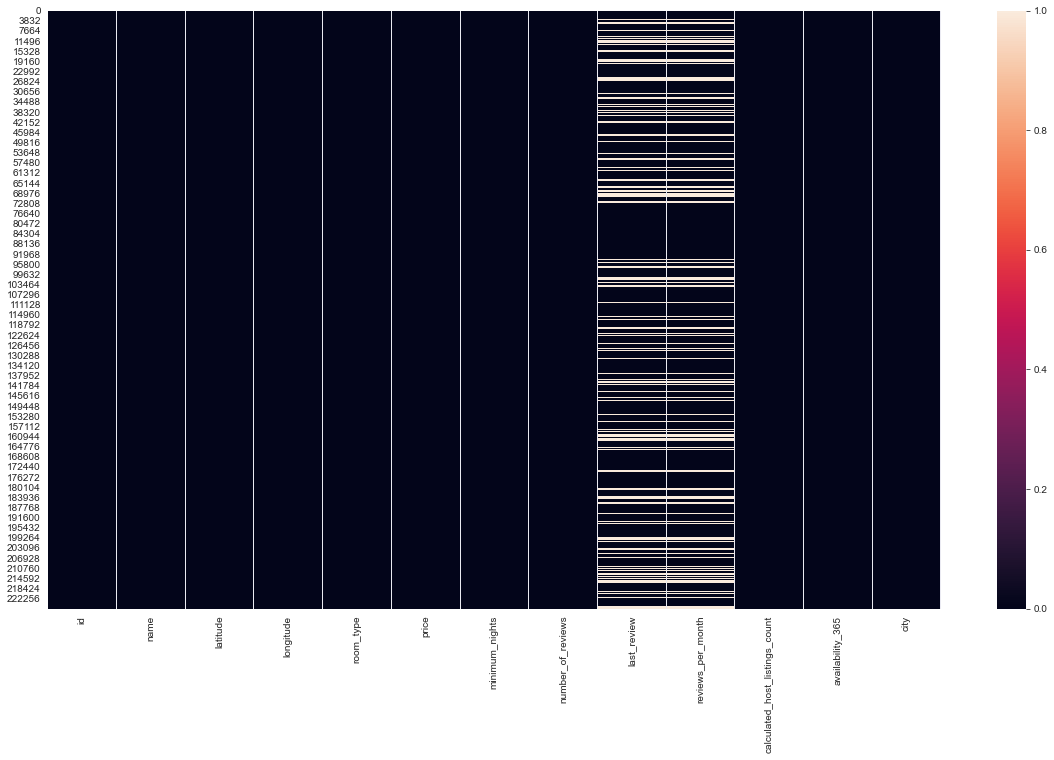

In [48]:
sns.heatmap(df.isna())

In [49]:
df.isnull().sum()/len(df)

id                                0.000000
name                              0.000124
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.215025
reviews_per_month                 0.215025
calculated_host_listings_count    0.000000
availability_365                  0.000000
city                              0.000000
dtype: float64

In [50]:
df['last_review']=pd.to_datetime(df['last_review'])

In [51]:
df.dtypes

id                                         int64
name                                      object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
city                                      object
dtype: object

In [79]:
numeric_features=[col for col in df.columns if df[col].dtypes !='O']
del numeric_features[0]
del numeric_features[5]
numeric_features

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [53]:
catagoric_features=[col for col in df.columns if df[col].dtypes=='O']
catagoric_features

['name', 'room_type', 'city']

In [56]:
df=df.dropna()
df.head()

,id,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,35.65146,-82.62792,Private room,60,1,138,2020-02-16,1.14,1,0,Asheville
1,80905,French Chic Loft,35.59779,-82.55540,Entire home/apt,470,1,114,2020-07-09,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,35.60670,-82.55563,Entire home/apt,75,30,89,2019-11-30,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,35.57864,-82.59578,Entire home/apt,90,1,267,2020-09-22,2.39,5,0,Asheville
4,160594,Historic Grove Park,35.61442,-82.54127,Private room,125,30,58,2015-10-19,0.52,1,0,Asheville


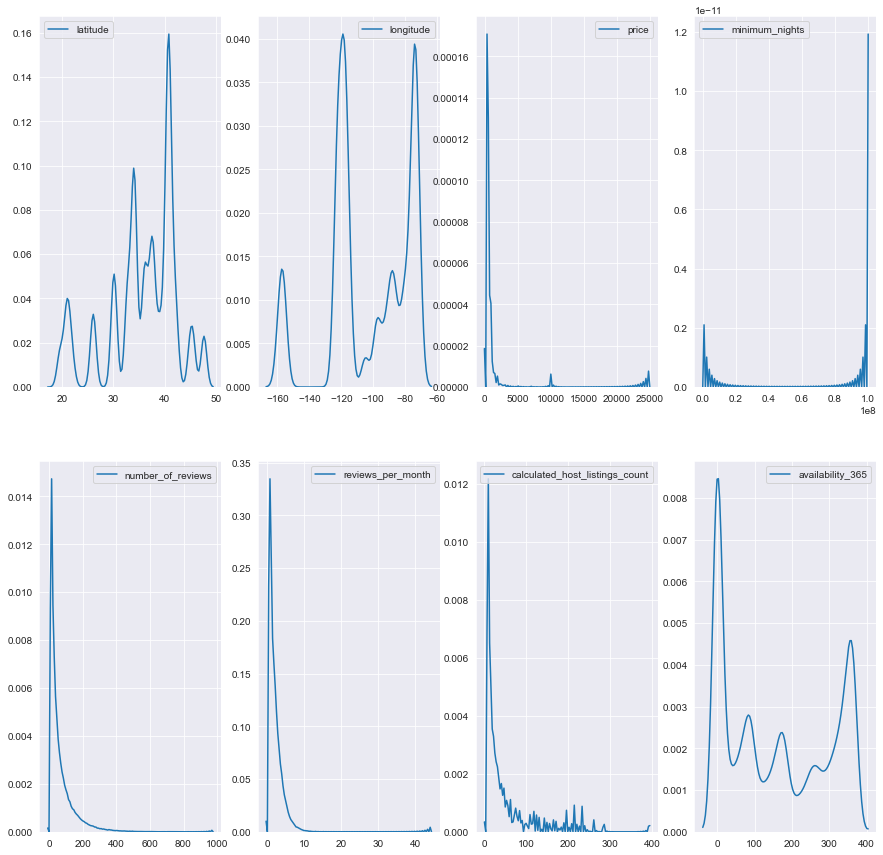

In [85]:
fig,axes=pl.subplots(nrows=2,ncols=4)
fig.set_figheight(15)
fig.set_figwidth(15)
aux=0
for row in axes:
    for col in row:
        sns.kdeplot(df[numeric_features[aux]],ax=col)
        aux+=1